<a href="https://colab.research.google.com/github/F1ameX/TUSUR_ML/blob/main/TUSUR_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/src_5hw/preprocessed_orders_short.csv', index_col = False)
df.head()

,Unnamed: 0,store_id,order_id,profit,delivery_distance,planned_prep_time,region_id,order_price,items_count,prepared_on_time
0,0,5014.0,20562761.0,45.5040,2205.0,15.0,683.0,30.49,2.0,1.0
1,2,3856.0,20562753.0,30.3360,1368.0,10.0,683.0,240.78,2.0,1.0
2,4,10825.0,20562723.0,43.6080,459.0,20.0,683.0,85.99,1.0,1.0
3,5,8535.0,20562639.0,11.3128,1749.0,10.0,685.0,80.09,5.0,1.0
4,10,11449.0,20562617.0,4.4240,1040.0,20.0,695.0,85.99,1.0,1.0


In [3]:
df.drop(df.columns[0], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5959 non-null   int64  
 1   store_id           5959 non-null   float64
 2   order_id           5959 non-null   float64
 3   profit             5959 non-null   float64
 4   delivery_distance  5959 non-null   float64
 5   planned_prep_time  5959 non-null   float64
 6   region_id          5959 non-null   float64
 7   order_price        5959 non-null   float64
 8   items_count        5959 non-null   float64
 9   prepared_on_time   5959 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 465.7 KB


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(['prepared_on_time'], axis = 1).copy()
y = df['prepared_on_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 52, test_size = 0.3, stratify = y)

In [5]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [14]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score


def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 2, 100)
  max_depth = trial.suggest_int('max_depth', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

  base_estimator = DecisionTreeClassifier(
      max_depth = max_depth,
      min_samples_leaf = min_samples_leaf,
      class_weight = 'balanced'
  )

  ensemble = BaggingClassifier(
      estimator = base_estimator,
      n_estimators = n_estimators,
      random_state = 52
  )

  score = cross_val_score(ensemble, X_train, y_train, cv = 5, scoring = 'accuracy').mean()
  return score


study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)
trial = study.best_trial

print('Точность модели по метрике Accuracy: ', trial.value)
print('Лучшие гиперпараметры :', trial.params)

[I 2024-12-11 04:26:14,862] A new study created in memory with name: no-name-ea2e8c5a-a467-46de-bfdb-e05ff3d7e061
[I 2024-12-11 04:26:17,833] Trial 0 finished with value: 0.7748666695386206 and parameters: {'n_estimators': 26, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7748666695386206.
[I 2024-12-11 04:26:20,942] Trial 1 finished with value: 0.7082226913080315 and parameters: {'n_estimators': 34, 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7748666695386206.
[I 2024-12-11 04:26:22,802] Trial 2 finished with value: 0.5888332687143698 and parameters: {'n_estimators': 36, 'max_depth': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7748666695386206.
[I 2024-12-11 04:26:27,692] Trial 3 finished with value: 0.7851810048966815 and parameters: {'n_estimators': 31, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.7851810048966815.
[I 2024-12-11 04:26:29,336] Trial 4 finished with value: 0.7614402848978302 and

Точность модели по метрике Accuracy:  0.8331343069257169
Лучшие гиперпараметры : {'n_estimators': 56, 'max_depth': 18, 'min_samples_leaf': 1}


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

best_params = study.best_params

best_model = BaggingClassifier(
    estimator = DecisionTreeClassifier(
        max_depth = best_params['max_depth'],
        min_samples_leaf = best_params['min_samples_leaf'],
        class_weight = 'balanced'
    ),
    n_estimators = best_params['n_estimators'],
    random_state = 52
)

random_forest = RandomForestClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_leaf = best_params['min_samples_leaf'],
    class_weight = 'balanced',
    random_state = 52
)

best_model.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

best_model_pred = best_model.predict(X_test)
random_forest_pred = random_forest.predict(X_test)

print('Качество выбранной модели BaggingClassifier, ансамбль из DecisionTreeClassifier')
print(classification_report(y_test, best_model_pred))
print('Метрика Accuracy: ', accuracy_score(y_test, best_model_pred))
print('Метрика Precision: ', precision_score(y_test, best_model_pred))
print('Метрика Recall: ', recall_score(y_test, best_model_pred))
print('Метрика F1-Score: ', f1_score(y_test, best_model_pred))

print('\nКачество модели RandomForestClassifier')
print(classification_report(y_test, random_forest_pred))
print('Метрика Accuracy: ', accuracy_score(y_test, random_forest_pred))
print('Метрика Precision: ', precision_score(y_test, random_forest_pred))
print('Метрика Recall: ', recall_score(y_test, random_forest_pred))
print('Метрика F1-Score: ', f1_score(y_test, random_forest_pred))

Качество выбранной модели BaggingClassifier, ансамбль из DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.14      0.00      0.01       294
         1.0       0.84      1.00      0.91      1494

    accuracy                           0.83      1788
   macro avg       0.49      0.50      0.46      1788
weighted avg       0.72      0.83      0.76      1788

Метрика Accuracy:  0.8327740492170023
Метрика Precision:  0.8354856822010107
Метрика Recall:  0.9959839357429718
Метрика F1-Score:  0.9087022900763359

Качество модели RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.36      0.02      0.03       294
         1.0       0.84      0.99      0.91      1494

    accuracy                           0.83      1788
   macro avg       0.60      0.51      0.47      1788
weighted avg       0.76      0.83      0.76      1788

Метрика Accuracy:  0.8333333333333334
Метрика Precision:  0.837091319052987

ValueError: x and y must have same first dimension, but have shapes (2,) and (100,)

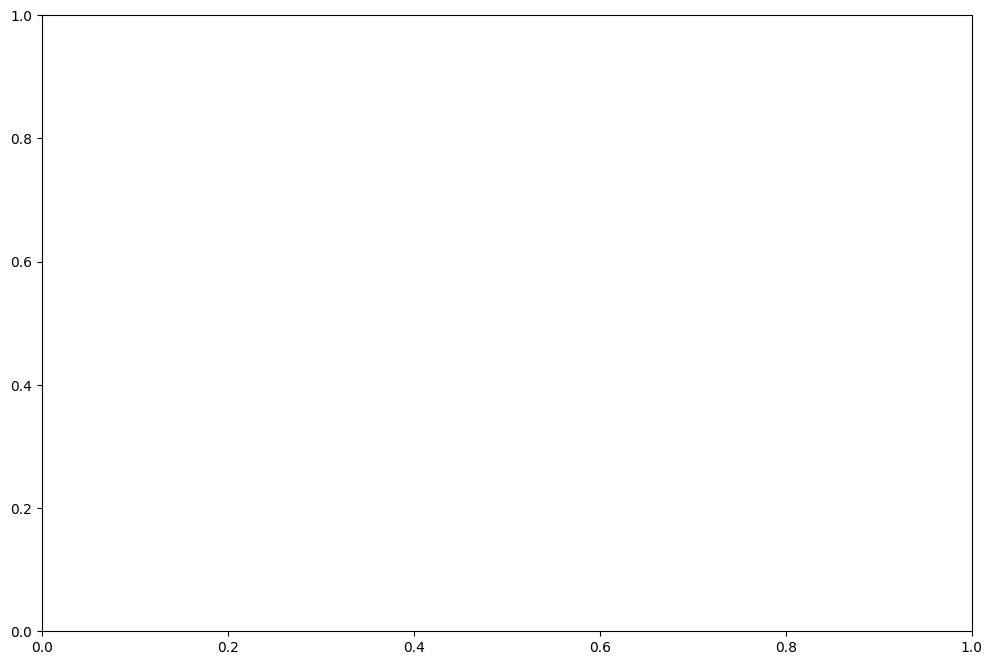

In [17]:
import matplotlib.pyplot as plt

max_depth = best_params['max_depth']
min_samples_leaf = best_params['max_depth']
scores = []

for n_estimators in range(1, 101):
  model = BaggingClassifier(
      estimator = DecisionTreeClassifier(
          max_depth = max_depth,
          min_samples_leaf = min_samples_leaf,
          class_weight = 'balanced'
      ),
      n_estimators = n_estimators,
      random_state = 52,
  )
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)
  scores.append(score)

plt.figure(figsize=(12, 8))
plt.show()